In [ ]:
from glob import glob 


result_root_dir = "/workspace/data/results"

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from scipy.stats import mode

def pkl_load(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# 모든 모델 결과 로드
pkl_files = glob(f"{result_root_dir}/*.pkl")
results_dict = {}

for pkl_file in pkl_files:
    model_name = pkl_file.split('/')[-1].split('.')[0]
    pkl_dict = pkl_load(pkl_file)
    results_dict[model_name] = pkl_dict
    print(f"✓ {model_name} 로드 완료")

print(f"\n총 {len(results_dict)}개 모델 로드됨")


In [ ]:
# 결과 딕셔너리에서 각 모델별 주요 metric을 DataFrame으로 정리

metrics_list = []

for model_name, result in results_dict.items():
    test_labels = result['test_labels']
    test_preds = result['test_preds']
    test_proba = result['test_proba']
    
    # test_preds와 test_proba는 fold별 리스트 (보통 5개)
    if isinstance(test_preds, dict) and 'CatBoost' in test_preds:
        preds_list = test_preds['CatBoost']
    else:
        preds_list = test_preds
    
    if isinstance(test_proba, dict) and 'CatBoost' in test_proba:
        proba_list = test_proba['CatBoost']
    else:
        proba_list = test_proba

    accs, precs, recalls, f1s, aucs = [], [], [], [], []
    for fold_pred, fold_proba in zip(preds_list, proba_list):
        accs.append(accuracy_score(test_labels, fold_pred))
        precs.append(precision_score(test_labels, fold_pred))
        recalls.append(recall_score(test_labels, fold_pred))
        f1s.append(f1_score(test_labels, fold_pred))
        aucs.append(roc_auc_score(test_labels, fold_proba))

    metrics_list.append({
        "Model": model_name,
        "Accuracy_mean": np.mean(accs),
        "Accuracy_std": np.std(accs),
        "Precision_mean": np.mean(precs),
        "Precision_std": np.std(precs),
        "Recall_mean": np.mean(recalls),
        "Recall_std": np.std(recalls),
        "F1_mean": np.mean(f1s),
        "F1_std": np.std(f1s),
        "ROC AUC Score_mean": np.mean(aucs),
        "ROC AUC Score_std": np.std(aucs),
    })

df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics.set_index('Model')

df_metrics = df_metrics.sort_values(by="F1_mean", ascending=False)
df_metrics.round(3)


## 2. ROC 곡선 비교


In [ ]:
# Soft Voting (평균 확률)을 사용한 ROC 곡선 비교 + best threshold 위치 별로 표시
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(results_dict)))

for idx, (model_name, result) in enumerate(results_dict.items()):
    test_labels = result['test_labels']
    test_proba = result['test_proba']
    
    # test_proba는 fold별로 저장되어 있음
    if isinstance(test_proba, dict) and 'CatBoost' in test_proba:
        proba_list = test_proba['CatBoost']
    elif isinstance(test_proba, list):
        proba_list = test_proba
    else:
        continue
    
    # Fold별 확률의 평균 계산 (Soft Voting)
    proba_array = np.array(proba_list)  # (n_folds, n_samples)
    avg_proba = np.mean(proba_array, axis=0)
    
    # ROC 곡선 및 best threshold 계산
    fpr, tpr, thresholds = roc_curve(test_labels, avg_proba)
    auc = roc_auc_score(test_labels, avg_proba)

    # best threshold: Youden's J statistic (tpr - fpr) 최대인 지점
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_thr = thresholds[best_idx]
    best_fpr = fpr[best_idx]
    best_tpr = tpr[best_idx]
    
    # ROC Curve plot
    plt.plot(fpr, tpr, lw=2.5, label=f'{model_name} (AUC={auc:.3f})', 
             color=colors[idx], alpha=0.8)
    # best threshold에 ★ 표시
    plt.scatter(best_fpr, best_tpr, marker='*', s=200, color=colors[idx], edgecolors='black', zorder=10)

    # threshold 및 좌표 주석(optional)
    plt.annotate(f'{best_thr:.2f}', (best_fpr, best_tpr), 
                 textcoords="offset points", xytext=(10,-15), ha='center', color=colors[idx], fontsize=10)

# 대각선 (랜덤 분류기)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1.5, label='Random (AUC=0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison (Soft Voting)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# Soft Voting (평균 확률)을 사용한 Precision-Recall 곡선 비교 + best threshold 위치 별로 표시
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(results_dict)))

for idx, (model_name, result) in enumerate(results_dict.items()):
    test_labels = result['test_labels']
    test_proba = result['test_proba']
    
    # test_proba는 fold별로 저장되어 있음
    if isinstance(test_proba, dict) and 'CatBoost' in test_proba:
        proba_list = test_proba['CatBoost']
    elif isinstance(test_proba, list):
        proba_list = test_proba
    else:
        continue
    
    # Fold별 확률의 평균 계산 (Soft Voting)
    proba_array = np.array(proba_list)  # (n_folds, n_samples)
    avg_proba = np.mean(proba_array, axis=0)
    
    # Precision-Recall curve 및 best threshold 계산
    precision, recall, thresholds = precision_recall_curve(test_labels, avg_proba)
    # f1-score 최대가 되는 지점 = best threshold
    # thresholds: n-1개, precision/recall: n개 (맨 앞 1주의)
    f1_scores = 2 * precision[1:] * recall[1:] / (precision[1:] + recall[1:] + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thr = thresholds[best_idx]
    best_prec = precision[best_idx+1]
    best_rec = recall[best_idx+1]
    auprc = average_precision_score(test_labels, avg_proba)
    
    # Precision-Recall Curve plot
    plt.plot(recall, precision, lw=2.5, label=f'{model_name} (AUPRC={auprc:.3f})', 
             color=colors[idx], alpha=0.8)
    # best threshold에 ★ 표시
    plt.scatter(best_rec, best_prec, marker='*', s=200, color=colors[idx], edgecolors='black', zorder=10)
    # threshold 및 좌표 주석(optional)
    plt.annotate(f'{best_thr:.2f}', (best_rec, best_prec), 
                 textcoords="offset points", xytext=(10,-15), ha='center', color=colors[idx], fontsize=10)

# 랜덤 분류기의 베이스라인 (양성 비율)
pos_ratio = np.mean(np.concatenate([result['test_labels'] for result in results_dict.values()]))
plt.hlines(pos_ratio, 0, 1, colors='gray', linestyles='--', label=f'Random (Pos ratio={pos_ratio:.2f})', lw=1.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves Comparison (Soft Voting)', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Confusion Matrix 비교


In [ ]:
# 각 모델별 Confusion Matrix 시각화
n_models = len(results_dict)
cols = 2
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
if n_models == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, (model_name, result) in enumerate(results_dict.items()):
    test_labels = result['test_labels']
    test_preds = result['test_preds']
    
    # test_preds는 fold별로 저장되어 있음
    if isinstance(test_preds, dict) and 'CatBoost' in test_preds:
        preds_list = test_preds['CatBoost']
    elif isinstance(test_preds, list):
        preds_list = test_preds
    else:
        continue
    
    # Hard Voting (Majority Vote)
    preds_array = np.array(preds_list)  # (n_folds, n_samples)
    hard_voting_pred = mode(preds_array, axis=0, keepdims=False).mode
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, hard_voting_pred)
    
    # 시각화
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'shrink': 0.8})
    ax.set_title(f'{model_name}\nAccuracy: {accuracy_score(test_labels, hard_voting_pred):.4f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Class 0', 'Class 1'])
    ax.set_yticklabels(['Class 0', 'Class 1'])

# 사용하지 않는 subplot 제거
for idx in range(n_models, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


## 4. Feature Importance 비교


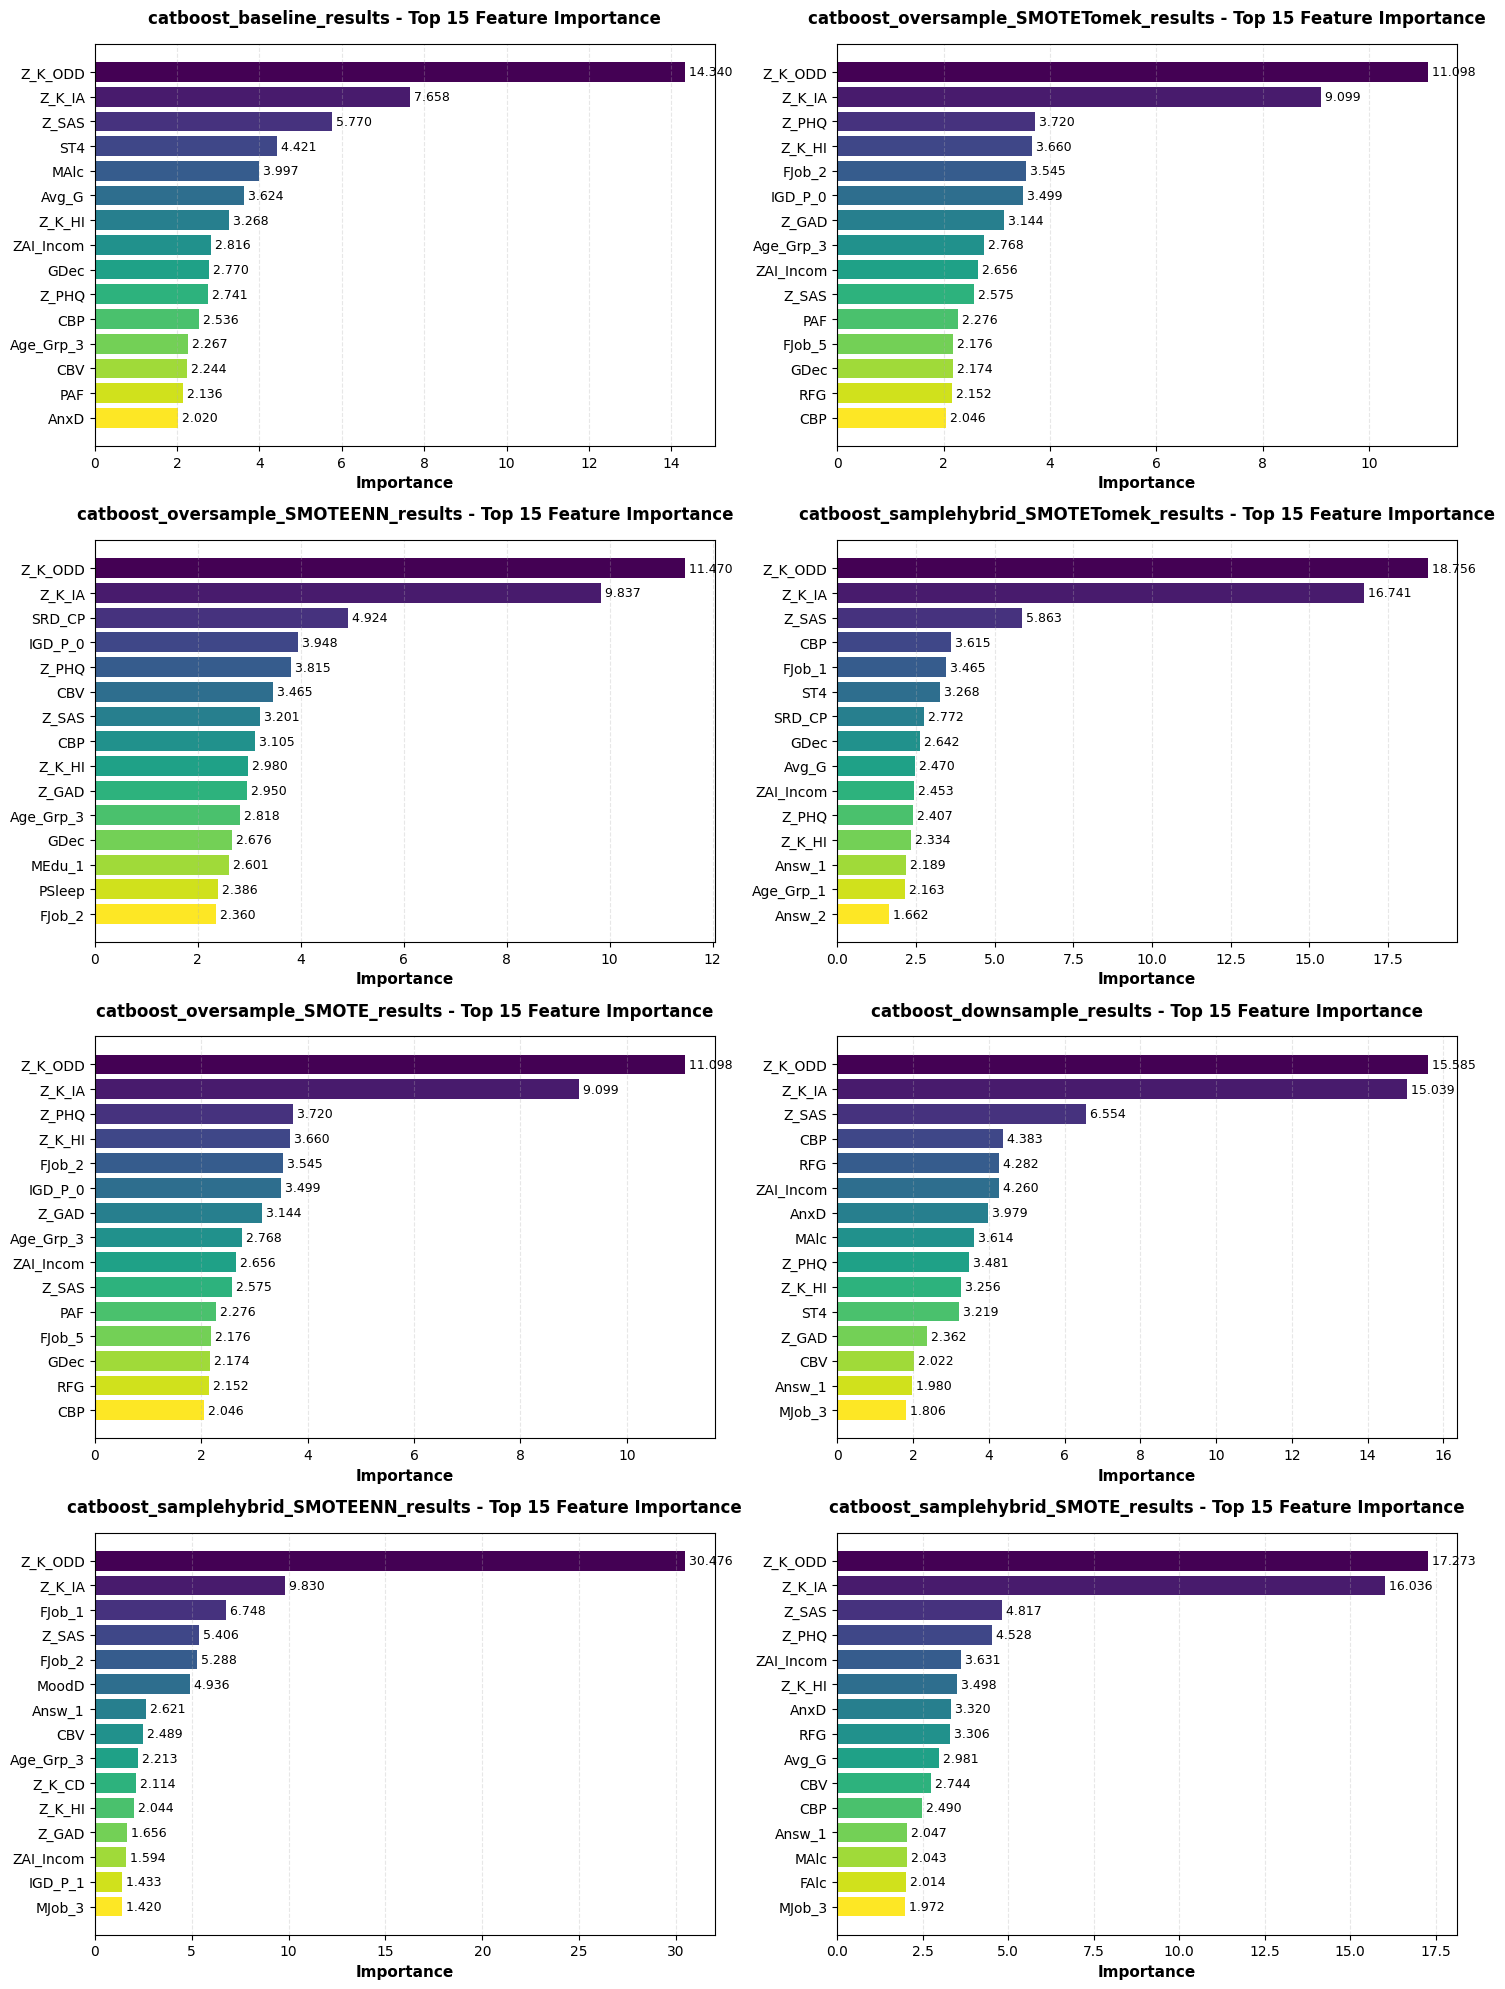


=== Feature Importance (Top 10) ===


[catboost_baseline_results]


,feature,importance
3,Z_K_ODD,14.339787
1,Z_K_IA,7.657595
29,Z_SAS,5.769617
28,ST4,4.420778
6,MAlc,3.997314
18,Avg_G,3.624387
2,Z_K_HI,3.267651
5,ZAI_Incom,2.816449
19,GDec,2.769990
12,Z_PHQ,2.740525



[catboost_oversample_SMOTETomek_results]


,feature,importance
3,Z_K_ODD,11.097894
1,Z_K_IA,9.099486
12,Z_PHQ,3.719832
2,Z_K_HI,3.660312
57,FJob_2,3.545315
63,IGD_P_0,3.499214
11,Z_GAD,3.143866
36,Age_Grp_3,2.768254
5,ZAI_Incom,2.655918
29,Z_SAS,2.574921



[catboost_oversample_SMOTEENN_results]


,feature,importance
3,Z_K_ODD,11.470111
1,Z_K_IA,9.836761
30,SRD_CP,4.923725
63,IGD_P_0,3.947527
12,Z_PHQ,3.815119
16,CBV,3.464737
29,Z_SAS,3.201219
17,CBP,3.104590
2,Z_K_HI,2.980362
11,Z_GAD,2.950425



[catboost_samplehybrid_SMOTETomek_results]


,feature,importance
3,Z_K_ODD,18.755717
1,Z_K_IA,16.740658
29,Z_SAS,5.863269
17,CBP,3.614860
56,FJob_1,3.464856
28,ST4,3.267752
30,SRD_CP,2.772266
19,GDec,2.642085
18,Avg_G,2.470182
5,ZAI_Incom,2.452647



[catboost_oversample_SMOTE_results]


,feature,importance
3,Z_K_ODD,11.097894
1,Z_K_IA,9.099486
12,Z_PHQ,3.719832
2,Z_K_HI,3.660312
57,FJob_2,3.545315
63,IGD_P_0,3.499214
11,Z_GAD,3.143866
36,Age_Grp_3,2.768254
5,ZAI_Incom,2.655918
29,Z_SAS,2.574921



[catboost_downsample_results]


,feature,importance
3,Z_K_ODD,15.585375
1,Z_K_IA,15.039288
29,Z_SAS,6.554248
17,CBP,4.382797
21,RFG,4.281591
5,ZAI_Incom,4.259994
24,AnxD,3.979471
6,MAlc,3.614285
12,Z_PHQ,3.480758
2,Z_K_HI,3.256472



[catboost_samplehybrid_SMOTEENN_results]


,feature,importance
3,Z_K_ODD,30.475933
1,Z_K_IA,9.830175
56,FJob_1,6.748427
29,Z_SAS,5.405820
57,FJob_2,5.288303
23,MoodD,4.935777
31,Answ_1,2.620795
16,CBV,2.489481
36,Age_Grp_3,2.213155
4,Z_K_CD,2.113765



[catboost_samplehybrid_SMOTE_results]


,feature,importance
3,Z_K_ODD,17.272811
1,Z_K_IA,16.035862
29,Z_SAS,4.816798
12,Z_PHQ,4.528403
5,ZAI_Incom,3.630544
2,Z_K_HI,3.497809
24,AnxD,3.319652
21,RFG,3.306299
18,Avg_G,2.981447
16,CBV,2.744287


In [24]:
# Feature Importance 시각화
n_models_with_fi = sum(1 for value in results_dict.values() if 'feature_importances' in value)

if n_models_with_fi > 0:
    # 모델별로 subplot 생성
    cols = 1 if n_models_with_fi == 1 else 2
    rows = (n_models_with_fi + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if n_models_with_fi == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if rows > 1 else [axes]
    
    plot_idx = 0
    for model_name, result in results_dict.items():
        if 'feature_importances' not in result:
            continue
            
        feature_importance_df = result['feature_importances']
        
        # 상위 15개 feature 선택
        top_features = feature_importance_df.head(15)
        
        # 막대 그래프 생성
        ax = axes[plot_idx]
        colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
        bars = ax.barh(range(len(top_features)), top_features['importance'].values, color=colors)
        
        # Y축에 feature 이름 표시
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'].values, fontsize=10)
        ax.invert_yaxis()  # 중요도 높은 순서대로 위에 표시
        
        # X축 레이블
        ax.set_xlabel('Importance', fontsize=11, fontweight='bold')
        ax.set_title(f'{model_name} - Top 15 Feature Importance', 
                     fontsize=12, fontweight='bold', pad=15)
        
        # 그리드 추가
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # 각 막대에 값 표시 (선택사항)
        for i, (idx, row) in enumerate(top_features.iterrows()):
            ax.text(row['importance'], i, f' {row["importance"]:.3f}', 
                   va='center', fontsize=9)
        
        plot_idx += 1
    
    # 사용하지 않는 subplot 제거
    for idx in range(plot_idx, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    # 테이블로도 출력
    print("\n=== Feature Importance (Top 10) ===\n")
    for model_name, result in results_dict.items():
        if 'feature_importances' in result:
            print(f"\n[{model_name}]")
            display(result['feature_importances'].head(10))
else:
    print("Feature importance 데이터가 없습니다.")

# 5. Shap Value 비교

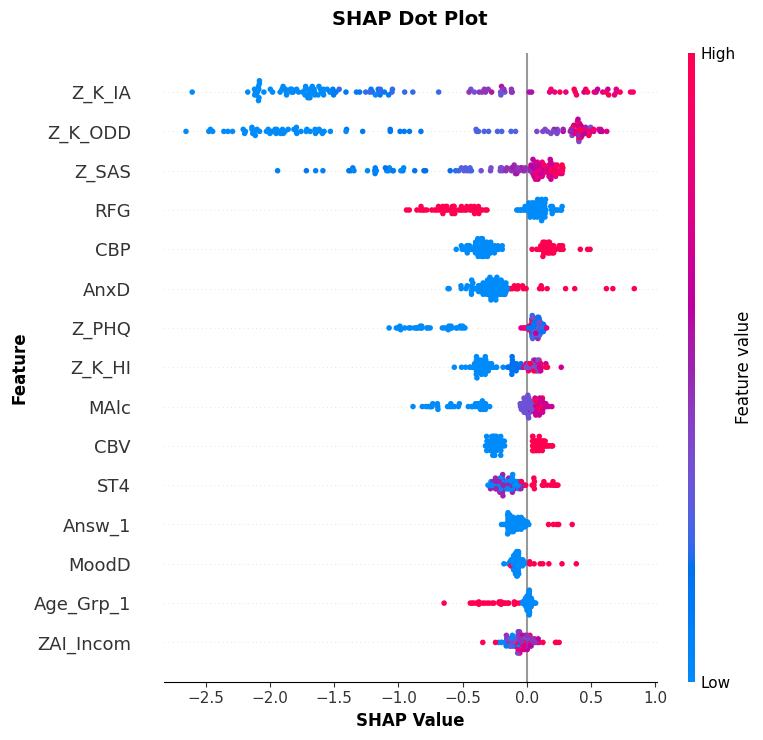

In [22]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# SHAP values 불러오기
shap_values_list = results_dict['catboost_downsample_results']['shap_values_test']['CatBoost']
test_inputs = results_dict['catboost_downsample_results']['test_inputs']

# SHAP values는 fold별로 리스트로 저장되어 있으므로 평균 계산
# 각 fold의 SHAP values를 numpy array로 변환 후 평균
shap_values_array = np.array(shap_values_list)  # (n_folds, n_samples, n_features)
shap_values_mean = np.mean(shap_values_array, axis=0)  # (n_samples, n_features)

# 한글 폰트 설정 (리눅스 기준으로 수정, 필요시 변경)
try:
    plt.rc('font', family='DejaVu Sans')
except:
    pass

# SHAP dot plot 생성
plt.figure(figsize=(10, 6))

# summary_plot로 dot plot 생성
shap.summary_plot(
    shap_values_mean, 
    test_inputs, 
    plot_type="dot",         # dot plot
    show=False,              # show=False로 설정하여 직접 제어
    color_bar=True,
    max_display=15           # 상위 15개 feature 표시
)

plt.xlabel("SHAP Value", fontsize=12, fontweight='bold')
plt.ylabel("Feature", fontsize=12, fontweight='bold')
plt.title("SHAP Dot Plot", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()